<a href="https://colab.research.google.com/github/yumehara/atmacup11/blob/main/notebooks/pytorch_tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
import pandas as pd
import numpy as np
from glob import  glob
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
!pip install python-vivid

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
def get_path(filename):
    return os.path.join('/content/drive/MyDrive/atmacup11', filename)

In [40]:
input_dir = get_path("inputs")
photo_dir = get_path("inputs/photos")

In [41]:
output_dir = get_path("outputs/tutorial_1")
os.makedirs(output_dir, exist_ok=True)

In [42]:
photo_pathes = glob(get_path("inputs/photos/*.jpg"))

In [43]:
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

### 画像データの読み込み

In [44]:
from PIL import Image

def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

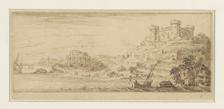

In [45]:
img = read_image(train_df['object_id'].iat[0])
img

### データ拡張 (data augmentation)

In [46]:
from torchvision import transforms as T

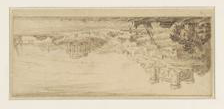

In [47]:
# p は変更する確率を表しています。今は変換がされた時の値を見たいので 1 を指定しました。
# 上下反転
T.RandomVerticalFlip(p=1)(img)

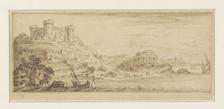

In [48]:
# 左右反転
T.RandomHorizontalFlip(p=1)(img)

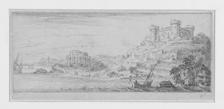

In [49]:
# グレースケール化
T.RandomGrayscale(1)(img)

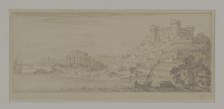

In [50]:
# 明るさ・コントラスト・彩度をランダムに変動させる
T.ColorJitter(brightness=.3, contrast=.5, saturation=[.8, 1.3])(img)

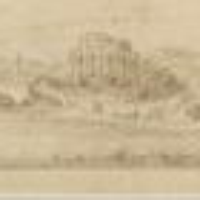

In [51]:
# 一部を切り出してリサイズ
T.RandomResizedCrop(size=(200, 200), )(img)

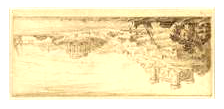

In [52]:
# 組み合わせ
converter = T.Compose([
    T.RandomVerticalFlip(p=1),
    T.ColorJitter(brightness=.5, contrast=.5)
])

converter(img)

### モデルの定義

In [53]:
import torch
from torchvision.models import resnet34
from torch import nn

In [54]:
# 事前学習を読み込まない
model = resnet34(pretrained=False)

In [55]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
converter = T.Compose([
    T.RandomVerticalFlip(p=1),
    T.ColorJitter(brightness=.5, contrast=.5),
    T.ToTensor()
])

In [57]:
x = converter(img)
# チャネル数 x 縦 x 横
x.shape

torch.Size([3, 109, 224])

In [58]:
# バッチサイズ x チャネル数 x 縦 x 横に変換
x.unsqueeze(0).shape

torch.Size([1, 3, 109, 224])

In [59]:
output = model(x.unsqueeze(0))
output.shape

torch.Size([1, 1000])

In [60]:
# モデルの最終層を書き換え
# 元の定義
# (fc): Linear(in_features=512, out_features=1000, bias=True)
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
output = model(x.unsqueeze(0))
output.shape

torch.Size([1, 1])

### 学習のスキームを定義


1.   入力データ x をモデルに入れて出力 z を作成
1.   x に対応する正解ラベル y と z を目的関数に入れてどのぐらいずれいているか(loss)を計算
1.   lossの情報を元にして最適化手法によってモデルを更新
リスト項目



### 目的関数の定義

In [61]:
criterion = nn.MSELoss()

### 最適化手法の定義

In [62]:
from torch.optim import Adam

# 最適化手法の定義. どのモデルのパラメータを更新したいか、を第一引数にする
# lr は learning_rate の略. 正解はないのですが adam だと 1e-3 などが使われることが多いです
optimizer = Adam(params=model.parameters(), lr=1e-3)

### 学習のサンプル

In [63]:
# 1. データを torch.Tensor の形式で用意
x = converter(img)
x = x.unsqueeze(0)

label = train_df['target'].iat[0]
label = torch.Tensor([label])
label = label.reshape(-1, 1)

# 2. モデルに入れて loss を objective で計算
output = model(x)
loss = criterion(output, label)

# 3. loss から optimizer が model を更新

# zero_grad は今ある勾配の情報をリセットする関数. このあとに計算される勾配を元にして最適化される
optimizer.zero_grad()

# loss から勾配を計算
loss.backward()

# 最適化ステップを一つすすめる
optimizer.step()

print(loss.item())

0.7956179976463318


### データセット

In [64]:
from torch.utils import data

IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose([
                                      *additional_items, 
                                      T.ToTensor(), 
                                      T.Normalize(mean=IMG_MEAN, std=IMG_STD)
                                      ])

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)

In [65]:
train_meta_df = train_df[['target', 'object_id']].copy()
train_meta_df['object_path'] = train_meta_df['object_id'].map(to_img_path)

dataset = AtmaDataset(meta_df=train_meta_df)

### DataLoader

In [66]:
NUM_WORKERS = 2

In [67]:
# この場合同時に 54 個の画像に対応した tensor と label が作られる
loader = data.DataLoader(dataset=dataset, batch_size=54, num_workers=NUM_WORKERS)

In [68]:
# 確認
for x_tensor, y in loader:
    break

# 最初の次元が先に設定した 54 になっている
x_tensor.shape, y.shape

(torch.Size([54, 3, 224, 224]), torch.Size([54]))

### 学習関数

In [69]:
# CUDA を使うので確認. google colab の場合 GPU accelerator をオンにしておいてください
assert torch.cuda.is_available()
DEVICE = torch.device("cuda")

In [70]:
from torch.optim.optimizer import Optimizer
from collections import defaultdict

def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()

    criterion = nn.MSELoss()

    # ロスの値を保存する用に dict を用意
    metrics = defaultdict(float)
    n_iters = len(train_loader)

    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_i = {
            # loss は tensor object なので item をつかって python object に戻す
            "loss": loss.item()
        }
        for k, v in metric_i.items():
            metrics[k] += v

    for k, v in metrics.items():
        metrics[k] /= n_iters

    return pd.Series(metrics).add_prefix("train_")

In [71]:
from vivid.utils import timer

n_epochs = 10

# GPU 環境で学習するため変換. この呼び出しは破壊的
model.to(DEVICE)
optimizer = Adam(params=model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):

    with timer(prefix="train: epoch={}".format(epoch)):
        score_train = train(
            model, optimizer, train_loader=loader
        )
    print(score_train)

    # 今は1回で抜ける
    break

train: epoch=1 29.170[s]
train_loss    2.245746
dtype: float64


### Cross Validation

In [72]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X=train_df, y=train_df['target']))

In [73]:
# 実験は最初の fold だけで考える
# cv = cv[:1]

### 検証

In [74]:
# from vivid.metrics import regression_metrics
from sklearn.metrics import mean_squared_error

def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()

    predicts = []

    for x_i, y_i in loader:

        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""
    # return regression_metrics(y_true, y_pred)

    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """

    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)

    valid_score = pd.Series(score)
    return valid_score.add_prefix("valid_"), pred

In [75]:
from tabulate import tabulate


def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    output_dir: str, 
    n_epochs=30) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """

    os.makedirs(output_i, exist_ok=True)

    optimizer = Adam(model.parameters(), lr=1e-3)

    # 0: 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    # 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)

    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=NUM_WORKERS
    )
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=NUM_WORKERS)

    # --- 保存のための変数定義
    score_df = pd.DataFrame()
    valid_score = np.inf
    valid_score_key = "valid_rmse"
    valid_best_pred = None

    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')

        # 1: 学習用データで学習を実行。学習時のロスを取得
        with timer(prefix="train: epoch={}".format(epoch)):
            score_train = train(
                model, optimizer, train_loader
            )

        # 2: 検証データでのスコアを計算
        with timer(prefix="validate"):
            score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)


        # --- 学習のロスと検証スコアの値をデータフレームに追加
        row = pd.concat([score_train, score_valid])
        row["epoch"] = epoch
        row = pd.DataFrame([row])
        print(tabulate(row, headers=row.columns))
        score_df = pd.concat([score_df, row], ignore_index=True)
        # ---

        # 今の検証スコアと過去最高のスコアを比較
        current_score = score_valid[valid_score_key]
        if current_score < valid_score:
            # スコア改善したときモデルを保存する
            print(f'validation score is improved!! {valid_score:.4f} -> {current_score:.4f}')
            torch.save(
                model.state_dict(), os.path.join(output_dir, 'model_best.pth')
            )
            valid_score = current_score
            valid_best_pred = y_valid_pred

    score_df.to_csv(os.path.join(output_dir, 'score.csv'), index=False)
    return valid_best_pred

In [76]:
def get_output_dir(n_cv: int):
    return os.path.join(output_dir, 'simple_resnet', f'cv={n_cv}')

oof = np.zeros((len(train_df), ), dtype=np.float32)

for i, (idx_tr, idx_valid) in enumerate(cv):
    output_i = get_output_dir(i)
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

    model.to(DEVICE)

    oof_i = run_fold(
        model=model, 
        train_df=train_meta_df.iloc[idx_tr], 
        valid_df=train_meta_df.iloc[idx_valid], 
        y_valid=train_meta_df['target'].values[idx_valid],
        output_dir=output_i,

        # 今は 1 ですぐ終わるようにしている. 本当は validation score の値を見つつ適宜設定する
        n_epochs=30
    )

    oof[idx_valid] = oof_i

start 1
train: epoch=1 23.010[s]
validate 2.978[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       2.20462      0.989498        1
validation score is improved!! inf -> 0.9895
start 2
train: epoch=2 23.121[s]
validate 2.957[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.963694       1.00419        2
start 3
train: epoch=3 22.941[s]
validate 2.967[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.978097       1.07585        3
start 4
train: epoch=4 22.865[s]
validate 3.028[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.937735      0.952955        4
validation score is improved!! 0.9895 -> 0.9530
start 5
train: epoch=5 23.561[s]
validate 2.977[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.960797      0.970979        5
start 6
train: epoch=6 23.006[s]
validate 2.997[s]
 

In [77]:
calculate_metrics(train_df['target'], oof)

{'rmse': 0.89911137820463}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


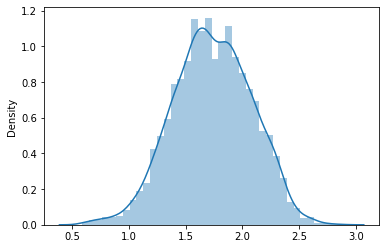

In [78]:
sns.distplot(oof)

In [91]:
score_list = []
for i in range(len(cv)):
    score = pd.read_csv(os.path.join(get_output_dir(i), 'score.csv'))
    score_list.append(score)

In [94]:
def plot_score(score_list, score_data):
    for score in score_list:
        plt.plot(score[score_data])

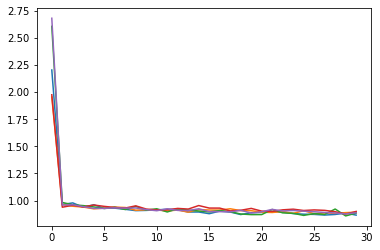

In [95]:
plot_score(score_list, 'train_loss')

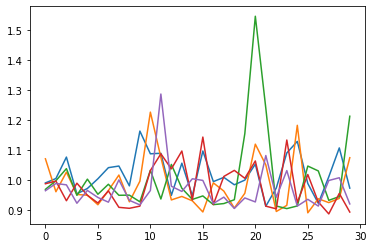

In [93]:
plot_score(score_list, 'valid_rmse')

### Test

In [80]:
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

# train と似たようなことをするので、次回から楽したいとおもって `create_metadata` という関数を作りました
test_meta_df = create_metadata(test_df)

# 学習時のデータ拡張はオフにしたいので is_train=False としている
test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=NUM_WORKERS)

In [81]:
test_predictions = []

for i in range(len(cv)):
    output_i = get_output_dir(i)

    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

    # 最も良かった重みを読みだす
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    model_path = os.path.join(output_i, 'model_best.pth')

    model.load_state_dict(torch.load(model_path))

    # GPU環境で予測するため `to` で変換
    model.to(DEVICE)

    with timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)

    test_predictions.append(y_pred_i)

pred cv=0 682.511[s]
pred cv=1 16.885[s]
pred cv=2 16.934[s]
pred cv=3 16.940[s]
pred cv=4 16.991[s]


In [82]:
# すべての予測の平均値を使う
pred_mean = np.array(test_predictions).mean(axis=0)

pd.DataFrame({
    "target": pred_mean
}).to_csv(os.path.join(output_dir, "0001__submission.csv"), index=False)

In [96]:
result = pd.DataFrame(pred_mean)
print(result.shape)
result.head()

(5919, 1)


,0
0,1.843189
1,1.890108
2,1.474255
3,1.791061
4,1.319280


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


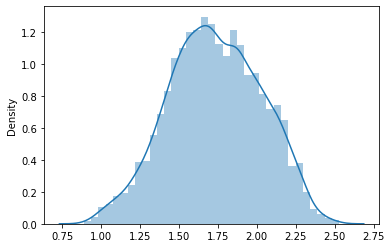

In [97]:
sns.distplot(result)